In [2]:
# Load dataset
dataset_path = "/kaggle/input/animefacedataset/images/"
from os import listdir
dataset = [dataset_path + i for i in listdir(dataset_path)]

# Verify if all images have been loaded
print(len(dataset))
print(dataset[0])

63565
/kaggle/input/animefacedataset/images/35715_2011.jpg


100%|██████████| 63565/63565 [03:37<00:00, 292.08it/s]


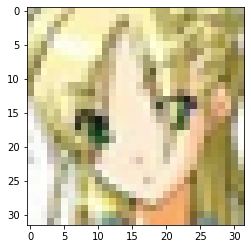

In [3]:
# Image Pre Processing

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tqdm

def image_processing_d1(path):
  img = PIL.Image.open(path)
  img = img.resize((32, 32))
  foo = np.array(img)
  return foo


AE_DATASET = []

with tqdm.tqdm(total=len(dataset)) as t:
  for img in dataset:
    i = image_processing_d1(img)
    #plt.imshow(i)
    #break
    AE_DATASET.append(i)
    t.update(1)

plt.imshow(AE_DATASET[0])

In [4]:
# Scaling dataset from 0-255 to 0-1
AE_DATASET = np.array(AE_DATASET)
AE_DATASET = AE_DATASET / 255

print(AE_DATASET.max(), AE_DATASET.min())
AE_DATASET.shape

1.0 0.0


(63565, 32, 32, 3)

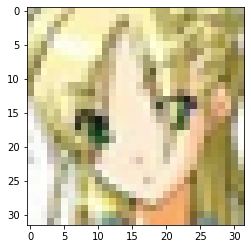

In [7]:
# Function to display image from array
def img_show(img):
  # Clipping between 0 and 1 to prevent overflows
  plt.imshow(np.clip(img, 0, 1))

# Check if it works
img_show(AE_DATASET[0])

In [8]:
# Import stuff for building AE
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Reshape, InputLayer, Input
from keras.layers import Conv2D, UpSampling2D, MaxPooling2D

In [9]:
# Build Encoder
encoder = Sequential()

encoder.add(InputLayer((32,32,3)))
encoder.add(Conv2D(filters = 198, kernel_size = (3, 3), activation='relu', padding='same'))
encoder.add(MaxPooling2D(pool_size = (2, 2), padding='same'))
encoder.add(Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', padding='same'))
encoder.add(MaxPooling2D(pool_size = (2, 2), padding='same'))
encoder.add(Conv2D(filters = 196, kernel_size = (3, 3), activation='relu', padding='same'))
encoder.add(MaxPooling2D(pool_size = (2, 2), padding='same'))
encoder.add(Flatten())
encoder.add(Dense(2500, activation='relu'))
encoder.add(Dense(784, activation='relu'))
encoder.add(Dense(512, activation='relu'))
encoder.add(Dense(256, activation='relu'))
print(encoder.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 198)       5544      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 198)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       456448    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 196)         451780    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 196)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [11]:
# Build Decoder
decoder = Sequential()

decoder.add(InputLayer((256)))
decoder.add(Dense(512, activation='relu'))
decoder.add(Dense(784, activation='relu'))
decoder.add(Dense(2500, activation='relu'))
decoder.add(Dense(3136, activation='relu'))
decoder.add(Reshape((4,4,196)))
decoder.add(Conv2D(196, (3, 3), activation='relu', padding='same'))
decoder.add(UpSampling2D((2, 2)))
decoder.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
decoder.add(UpSampling2D((2, 2)))
decoder.add(Conv2D(198, (3, 3), activation='relu', padding='same'))
decoder.add(UpSampling2D((2, 2)))
decoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
print(decoder.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_9 (Dense)              (None, 784)               402192    
_________________________________________________________________
dense_10 (Dense)             (None, 2500)              1962500   
_________________________________________________________________
dense_11 (Dense)             (None, 3136)              7843136   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 196)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 196)         345940    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 196)        

In [12]:
# Define stuff to build AE
inp = Input((32,32,3))
code = encoder(inp)
reconstruction = decoder(code)

In [13]:
# Build Auto Encoder
autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 256)               11250304  
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 3)         11598931  
Total params: 22,849,235
Trainable params: 22,849,235
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Train the Model
history = autoencoder.fit(
    x = AE_DATASET,
    y = AE_DATASET,
    epochs=150,
    batch_size=256
)

Epoch 1/150
249/249 [==============================] - 21s 65ms/step - loss: 0.0586
Epoch 2/150
249/249 [==============================] - 16s 64ms/step - loss: 0.0363
Epoch 3/150
249/249 [==============================] - 16s 64ms/step - loss: 0.0311
Epoch 4/150
249/249 [==============================] - 16s 64ms/step - loss: 0.0281
Epoch 5/150
249/249 [==============================] - 16s 64ms/step - loss: 0.0266
Epoch 6/150
249/249 [==============================] - 16s 64ms/step - loss: 0.0255
Epoch 7/150
249/249 [==============================] - 16s 64ms/step - loss: 0.0248
Epoch 8/150
249/249 [==============================] - 16s 64ms/step - loss: 0.0245
Epoch 9/150
249/249 [==============================] - 16s 64ms/step - loss: 0.0233
Epoch 10/150
249/249 [==============================] - 16s 64ms/step - loss: 0.0223
Epoch 11/150
249/249 [==============================] - 16s 64ms/step - loss: 0.0217
Epoch 12/150
249/249 [==============================] - 16s 64ms/step - lo

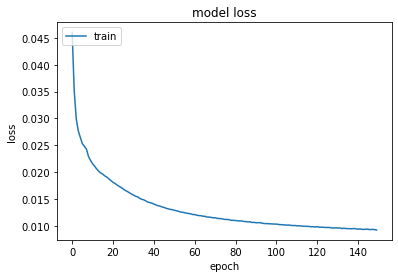

In [15]:
# Plot Training History
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

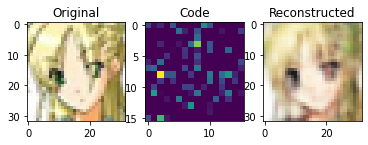

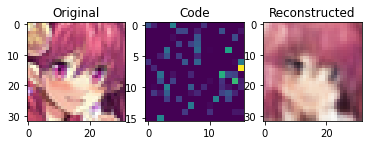

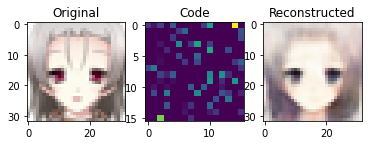

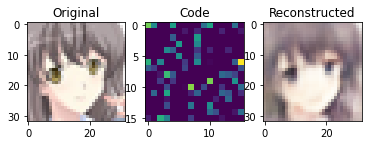

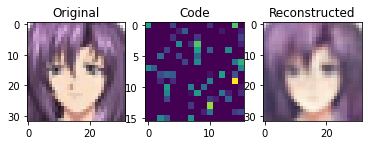

In [16]:
# Plot Reconstructions from Latent Space
# Reconstruction success
def visualize(img,encoder,decoder):
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    img_show(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape((16,16)))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco)
    plt.show()

for i in range(5):
    img = AE_DATASET[i]
    visualize(img,encoder,decoder)

In [18]:
# Get all Image Latent Vectors
x = encoder.predict(AE_DATASET)
print(x.shape)

(63565, 256)


In [21]:
import pandas as pd

df = pd.DataFrame(x)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.581800,0.087785,0.298249,0.0,0.699201,0.0,0.0,0.0,0.0,1.393541,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
1,0.229131,0.077998,0.000000,0.0,0.394114,0.0,0.0,0.0,0.0,0.126806,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
2,0.566974,0.203468,0.700190,0.0,1.011666,0.0,0.0,0.0,0.0,0.630096,...,0.0,0.486592,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
3,0.953464,0.584891,0.000000,0.0,0.686920,0.0,0.0,0.0,0.0,0.452360,...,0.0,0.221937,0.0,0.0,0.0,0.0,0.06687,0.0,0.0,0.0
4,0.436676,0.000000,0.000000,0.0,0.157760,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.388921,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0


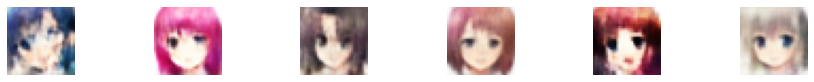

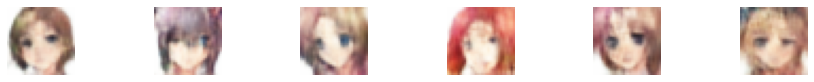

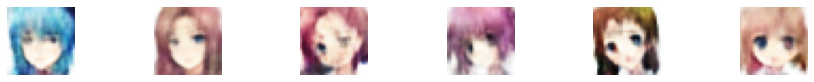

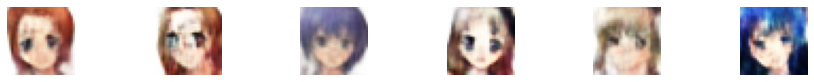

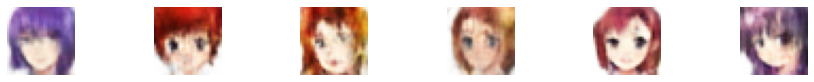

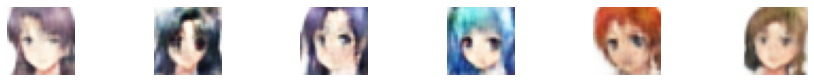

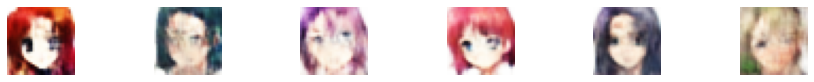

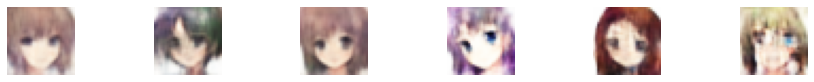

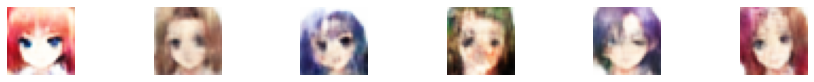

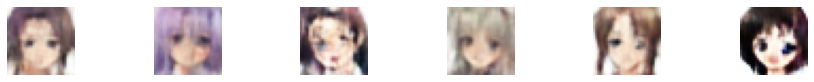

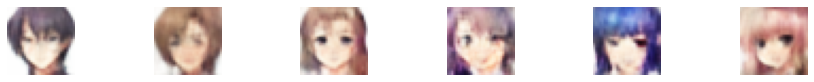

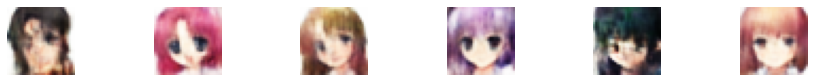

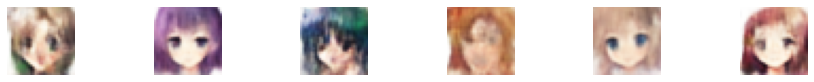

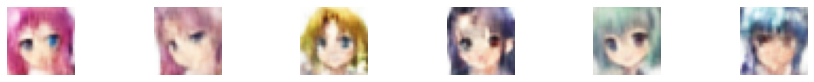

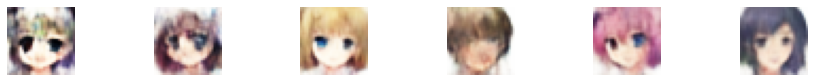

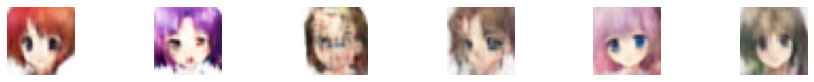

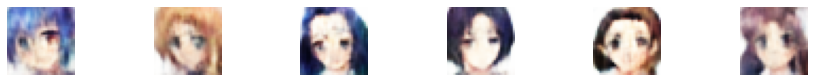

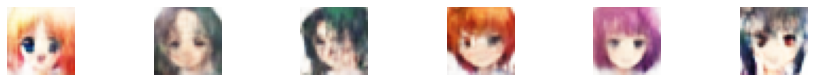

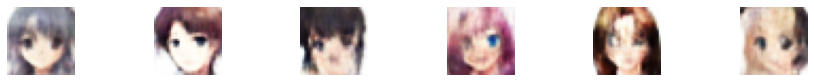

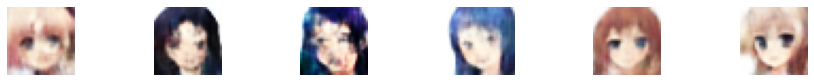

In [48]:
# Generate faces Randomly
def generate_images(n_to_show):
  reconst_images = decoder.predict(np.random.normal(0,1,size=(n_to_show,256)))

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img)

for i in range(20):
    generate_images(6) 

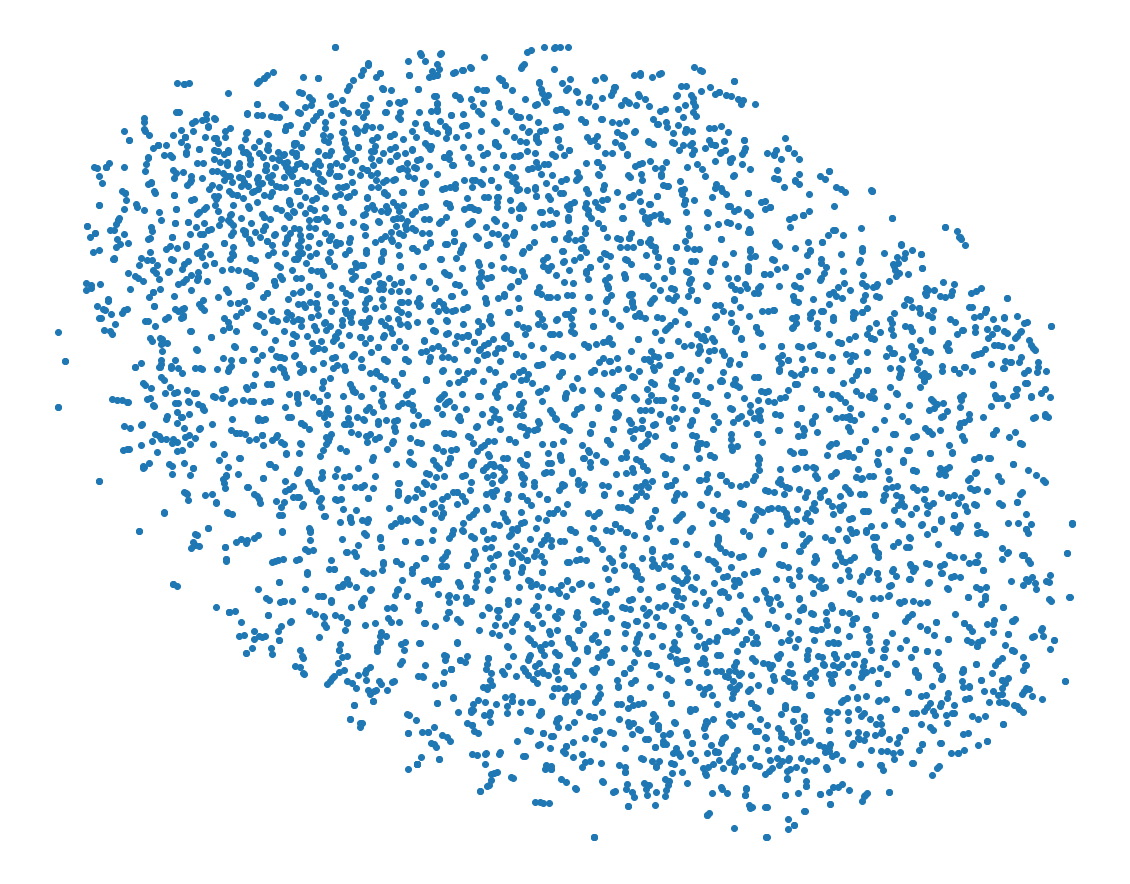

In [46]:
# Visualise Latent Space with t-SNE

from sklearn.manifold import TSNE

tsne = TSNE()
x_2D = tsne.fit_transform(x[:5000])
x_2D = (x_2D - x_2D.min()) / (x_2D.max() - x_2D.min())
plt.figure(figsize=(20,16))
plt.scatter(x_2D[:, 0], x_2D[:, 1])
plt.axis("off")
plt.show()

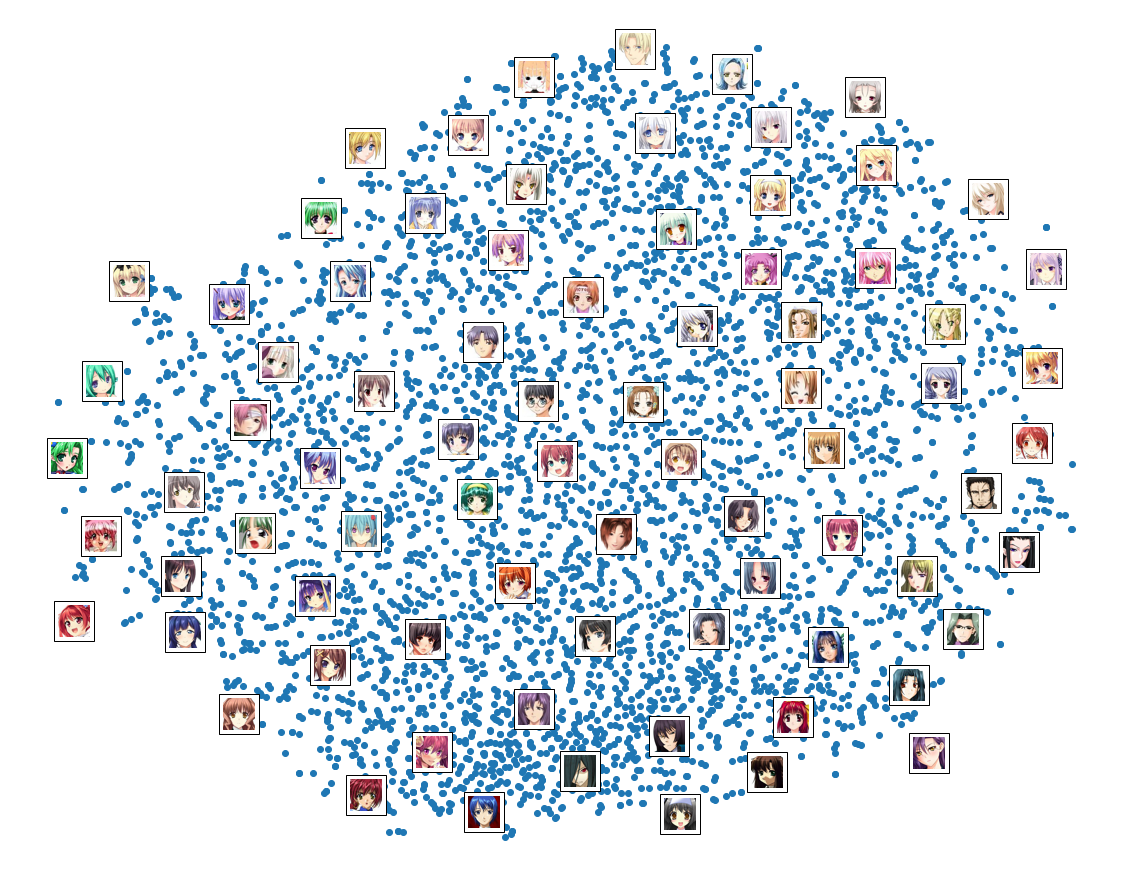

In [45]:
# Adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
import matplotlib as mpl

plt.figure(figsize=(20, 16))
plt.scatter(x_2D[:, 0], x_2D[:, 1])
image_positions = np.array([[1., 1.]])
for index, position in enumerate(x_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.005: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(AE_DATASET[:5000][index]),
            position)
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()